In [1]:
import pandas as pd
import dask.dataframe as dd
import os
import math
import geopandas as gpd
from shapely.geometry import Polygon

import config
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])

filepath = [os.path.join(config.process_folder, file)
            for file in os.listdir(config.process_folder)
            if file.endswith('.txt') and not file.startswith('.')]

assert len(filepath) == 25

## Original Dataset

使用Dask并行计算库，延迟读取所有数据集文件。

In [2]:
# load all the data into a Dask DataFrame lazily
ddf = dd.read_csv(filepath, header=None, names=['id', 'lat', 'lon', 'st', 'dt'])

# remove the 'st' column, as it's not needed
ddf = ddf.drop(columns=['st'])

# convert the 'dt' column from string to datetime format
ddf['dt'] = dd.to_datetime(ddf['dt'])

# display the dataframe
ddf.head()

,id,lat,lon,dt
0,1,30.624806,104.136604,2014-08-03 21:18:46
1,1,30.624809,104.136612,2014-08-03 21:18:15
2,1,30.624811,104.136587,2014-08-03 21:20:17
3,1,30.624811,104.136596,2014-08-03 21:19:16
4,1,30.624811,104.136619,2014-08-03 21:17:44


## Func: dealVehicle.py, dealHighFreVehicle.py -> VehicleData_dealed/result.txt

统计每名工人在当月出现天数（`worker_days`），统计当月每天有哪些工人（`date_workers`）。

In [3]:
# paths for output files
worker2days_path = config.worker2days_output
date2workers_path = config.date2workers_output

# process and save the data only if it hasn't been done before
if not all(os.path.exists(path) for path in [worker2days_path, date2workers_path]):
    
    # extract date and calculate necessary statistics
    ddf['date'] = ddf['dt'].dt.date
    worker2days = ddf.drop_duplicates(subset=['id', 'date']).groupby('id')['date'].count().to_frame('days')
    date2workers = ddf.drop_duplicates(subset=['id', 'date']).groupby('date')['id'].unique().to_frame('workers')

    # compute and save the results
    worker2days, date2workers = dd.compute(worker2days, date2workers)
    worker2days.to_csv(worker2days_path)
    date2workers['workers'] = date2workers['workers'].apply(list)
    date2workers.to_csv(date2workers_path)

# load the data
worker2days = pd.read_csv(worker2days_path)
date2workers = pd.read_csv(date2workers_path)

In [4]:
worker2days

,id,days
0,1,25
1,2,25
2,3,25
3,4,24
4,5,25
...,...,...
14855,14861,1
14856,14862,1
14857,14863,1
14858,14864,1


In [5]:
date2workers

,date,workers
0,2014-08-03,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2014-08-04,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 13606, 10, 11, 12,..."
2,2014-08-05,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 13606, 10, 11, 12,..."
3,2014-08-06,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 10, 11, 12,..."
4,2014-08-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 13606, 10, ..."
5,2014-08-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 13606, 10, ..."
6,2014-08-10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 10, 11, 12,..."
7,2014-08-11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 13606, 10, ..."
8,2014-08-12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 10, 11, 12,..."
9,2014-08-14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 14339, 10, 11, 12,..."


In [6]:
# process and save active workers if not already done
threshold = config.active_threshold
output_path = config.worker2days_active_output

if not os.path.exists(output_path):
    # filter active workers
    active_workers = worker2days[worker2days['days'] >= threshold]  
    # compute and save results
    active_workers.to_csv(output_path)

active_workers = pd.read_csv(output_path)
active_workers

,Unnamed: 0,id,days
0,0,1,25
1,1,2,25
2,2,3,25
3,4,5,25
4,7,8,25
...,...,...,...
9569,13599,13600,25
9570,13600,13601,25
9571,13602,13603,25
9572,13603,13604,25


## Func: getMaxMinLonLat.py

以上述活跃司机为基准，从中选择2000名工人，横跨当月每一天，统计最大最小的经纬度。

In [7]:
output_path = config.selected_worker_output
n_workers = config.number_of_workers

# select and save top N workers based on ID if not already done
if not os.path.exists(output_path):
    selected_workers = active_workers['id'].sort_values(ascending=True)[:n_workers]
    pd.DataFrame(selected_workers).to_csv(output_path, index=False)

# load the selected workers' IDs
selected_workers = pd.read_csv(output_path)
selected_workers

,id
0,1
1,2
2,3
3,5
4,8
...,...
1135,1618
1136,1619
1137,1620
1138,1621


In [8]:
output_path = config.geographical_bound_output

if not os.path.exists(output_path):
    # calculate and save geographical bounds for selected workers
    bounds_df = ddf[ddf['id'].isin(selected_workers['id'])][['lat', 'lon']]
    bounds_to_compute = {
        'min_lat': bounds_df['lat'].min(),
        'max_lat': bounds_df['lat'].max(),
        'min_lon': bounds_df['lon'].min(),
        'max_lon': bounds_df['lon'].max()
    }
    computed_bounds = dd.compute(*bounds_to_compute.values())

    # save computed bounds to DataFrame and CSV
    bounds_columns = ['min_lat', 'max_lat', 'min_lon', 'max_lon']
    geographical_bound = pd.DataFrame([computed_bounds], columns=bounds_columns)
    geographical_bound.to_csv(output_path, index=False)

# read the saved geographical bounds
geographical_bound = pd.read_csv(output_path).iloc[0]
min_lat, max_lat, min_lon, max_lon = geographical_bound
min_lat, max_lat, min_lon, max_lon

(30.29066, 31.032437, 103.269824, 104.609676)

## Func: setAllDataGridLabel.py

1. 添加栅格标签列，将离散的数据点聚集至栅格中；
2. 按照每一天统计途径该栅格的工人有多少个，有哪些。

<Axes: >

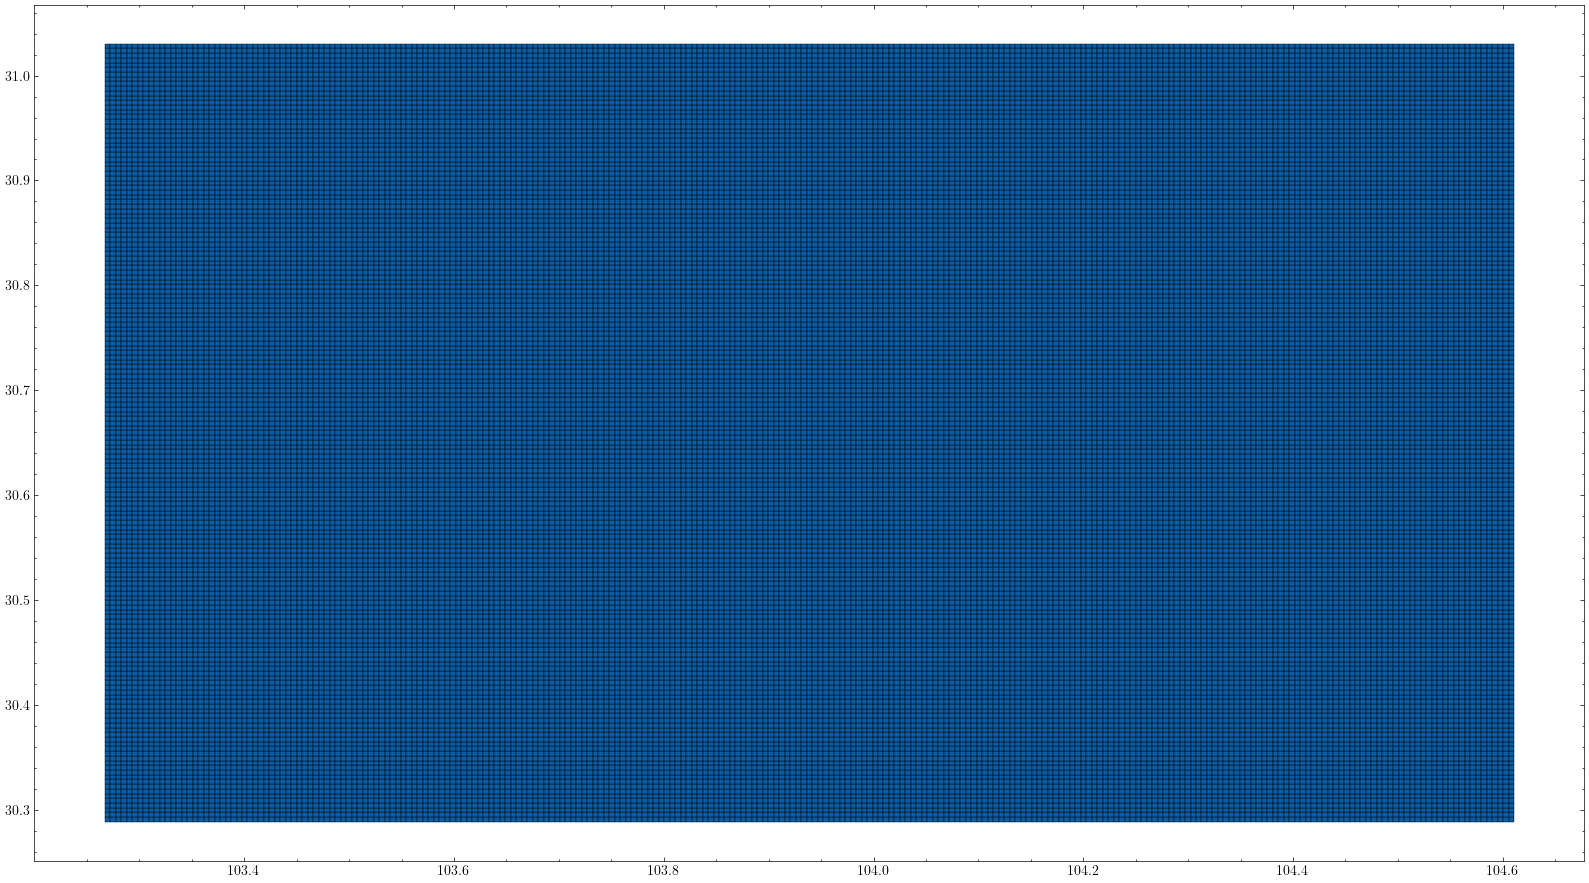

In [10]:
grid_size = config.grid_accuracy
earth_radius = config.earth_radius

# calculate latitude and longitude increments
delta_lat = grid_size * 360 / (2 * math.pi * earth_radius)
delta_lon = grid_size * 360 / (2 * math.pi * earth_radius * math.cos((min_lat + max_lat) * math.pi / 360))

def gps_to_grid(lat, lon):
    """ Calculate grid index for a given GPS coordinate """
    lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
    lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
    return lat_index, lon_index

def grid_to_gps(lat_index, lon_index):
    """ Calculate GPS coordinates of the center point for a given grid index """
    lat = lat_index * delta_lat + min_lat
    lon = lon_index * delta_lon + min_lon
    return lat, lon

# Create a list to hold grid data
grid_data_list = []

# Calculate the number of grids to generate
num_lon_grids = int((max_lon - min_lon) / delta_lon) + 1
num_lat_grids = int((max_lat - min_lat) / delta_lat) + 1

# Generate grids and populate the dataframe
for i in range(num_lon_grids):
    center_lon = i * delta_lon + min_lon
    for j in range(num_lat_grids):
        center_lat = j * delta_lat + min_lat

        grid_polygon = Polygon([
            (center_lon - delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat - delta_lat / 2),
            (center_lon + delta_lon / 2, center_lat + delta_lat / 2),
            (center_lon - delta_lon / 2, center_lat + delta_lat / 2)
        ])

        grid_data_list.append({
            'lon_index': i, 
            'lat_index': j,
            'lon_center': center_lon, 
            'lat_center': center_lat,
            'geometry': grid_polygon
        })

# Convert the list to a GeoDataFrame
grid_data = gpd.GeoDataFrame(grid_data_list, columns=['lon_index', 'lat_index', 'lon_center', 'lat_center', 'geometry'])
grid_data.set_geometry('geometry', inplace=True)

# Plot the grid data
grid_data.plot(edgecolor='black', linewidth=0.3, figsize=(20, 15))

In [11]:
grid_data

,lon_index,lat_index,lon_center,lat_center,geometry
0,0,0,103.269824,30.290660,"POLYGON ((103.26721 30.28841, 103.27244 30.288..."
1,0,1,103.269824,30.295157,"POLYGON ((103.26721 30.29291, 103.27244 30.292..."
2,0,2,103.269824,30.299653,"POLYGON ((103.26721 30.29740, 103.27244 30.297..."
3,0,3,103.269824,30.304150,"POLYGON ((103.26721 30.30190, 103.27244 30.301..."
4,0,4,103.269824,30.308646,"POLYGON ((103.26721 30.30640, 103.27244 30.306..."
...,...,...,...,...,...
42400,256,160,104.608045,31.010117,"POLYGON ((104.60543 31.00787, 104.61066 31.007..."
42401,256,161,104.608045,31.014613,"POLYGON ((104.60543 31.01237, 104.61066 31.012..."
42402,256,162,104.608045,31.019110,"POLYGON ((104.60543 31.01686, 104.61066 31.016..."
42403,256,163,104.608045,31.023607,"POLYGON ((104.60543 31.02136, 104.61066 31.021..."


In [12]:
ddf.head()

,id,lat,lon,dt
0,1,30.624806,104.136604,2014-08-03 21:18:46
1,1,30.624809,104.136612,2014-08-03 21:18:15
2,1,30.624811,104.136587,2014-08-03 21:20:17
3,1,30.624811,104.136596,2014-08-03 21:19:16
4,1,30.624811,104.136619,2014-08-03 21:17:44


In [13]:
if not os.path.exists(config.ddf_output):
    # Calculate longitude index
    ddf['lon_index'] = ((ddf['lon'] - (min_lon - delta_lon / 2)) / delta_lon).astype('int')
    # Calculate latitude index
    ddf['lat_index'] = ((ddf['lat'] - (min_lat - delta_lat / 2)) / delta_lat).astype('int')
    # Save the DataFrame with grid indices to a Parquet file
    ddf.to_parquet(config.ddf_output)

# store original dataset in parquets 
ddf = dd.read_parquet(config.ddf_output)
ddf.head()

,id,lat,lon,dt,lon_index,lat_index
0,1,30.624806,104.136604,2014-08-03 21:18:46,166,74
1,1,30.624809,104.136612,2014-08-03 21:18:15,166,74
2,1,30.624811,104.136587,2014-08-03 21:20:17,166,74
3,1,30.624811,104.136596,2014-08-03 21:19:16,166,74
4,1,30.624811,104.136619,2014-08-03 21:17:44,166,74


In [14]:
if not os.path.exists(config.task_output):
    tasks = ddf[['lon_index', 'lat_index']].drop_duplicates().compute()
    tasks.to_csv(config.task_output, index=False)

tasks = pd.read_csv(config.task_output)
tasks

,lon_index,lat_index
0,166,74
1,165,75
2,166,75
3,166,76
4,166,77
...,...,...
21288,224,117
21289,224,118
21290,109,126
21291,109,127


<Axes: >

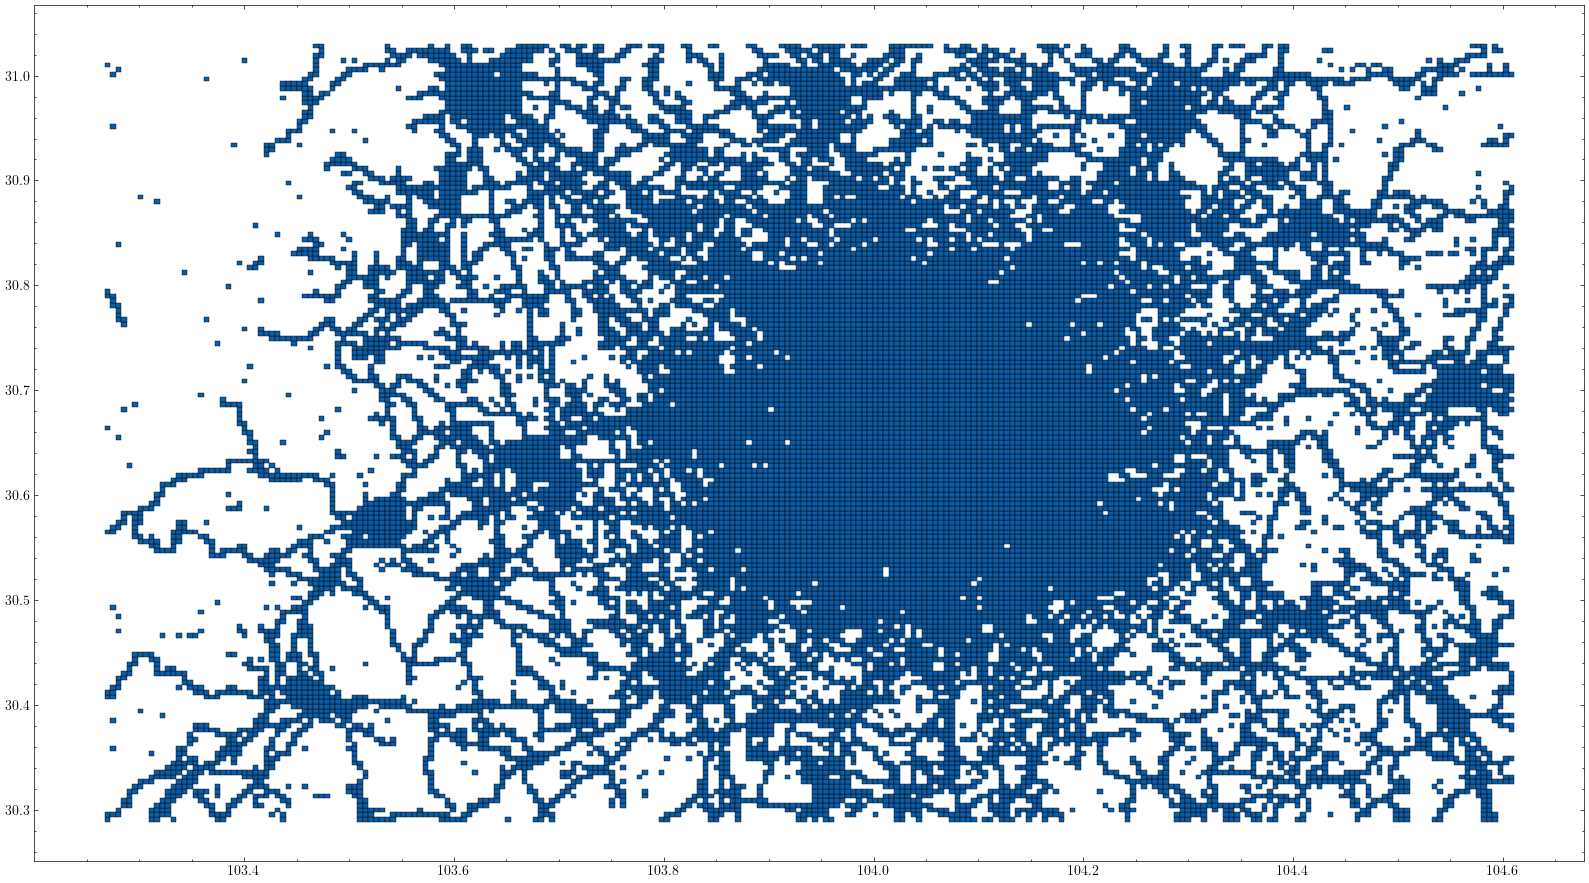

In [16]:
grid_data_filtered = grid_data.merge(tasks[['lon_index', 'lat_index']], 
                                     on=['lon_index', 'lat_index'], 
                                     how='inner')
grid_data_filtered.plot(edgecolor='black', linewidth=0.3, figsize=(20, 15))

## getArrivePro.py, getQualific.py

对一个特定的工人、任务：

Arrivepro：有记录天数除以总天数计算，代表到达当前任务的概率；

qPro：质量达标（停留秒数大于阈值）天数除以有记录天数，代表完成该任务的概率。